#Support Vector Binary Classification of Disease State with Cycle Averaged Sensor Data
##Input Data: 15 sensor map of the cardiac cycle over a 1 second period ($15\times2000$)

##Investigation of:
* Classifier prediction performance.
* Out of sample prediction error.
* The effect of kernel choice: Linear, Polynomial, RBF.
* The effect of subsampling the time series. From full 2000 down to 10.

**Daniel Wilson and John Mooney**

In [3]:
#Healthy defined as 0
#Unhealthy defined as 1

In [4]:
import mlpy.wavelet
import mcg
import numpy as np
import datetime
import timeit
import time
import copy
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
import pandas as pd
import time
import gc
from matplotlib.mlab import PCA
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
from sklearn import svm
from sklearn import preprocessing
#matplotlib

mcg.deviceID = 'mk1'
mcg.setDeviceID()

#%matplotlib inline
from skimage.feature import match_template

mk1


In [5]:
from sklearn import cross_validation
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV #optimizing gamma and c
from sklearn.grid_search import RandomizedSearchCV #optimizing gamma and c
from sklearn.metrics import roc_curve, auc
from sklearn.learning_curve import learning_curve
from scipy import interp
import scipy
import random
import sys
from sklearn.learning_curve import learning_curve
import random
from matplotlib.colors import Normalize
from sklearn.metrics import confusion_matrix

In [26]:
%matplotlib inline

# Import training data

In [16]:
path60  = '/home/john/Dropbox/Mubashir/6060DataFrame.pkl'
df60 = pd.read_pickle(path60)
#Randomly shuffle lst
df60 = df60.iloc[np.random.permutation(len(df60))]

In [17]:
df60.columns

Index([u'Classification', u'Coil Data'], dtype='object')

In [12]:
#Overall patient to healty ratio
P2Hratio(np.asarray(df60['Classification'].values.tolist()))

0.49


# Nested Cross Validation
## Split Data into 4 sets

## CoilData subsampled 40

In [18]:
def p_fold(df, p, column='Coil Data'):
    """Split df into p sets. For use in a p/len(data) versus rest nested cross validation. 
    """
    length = len(df.index.tolist())
    #print length
    #print p
    chunksize = length/p
    #print chunksize
    dataset = []
    for i in range(p):
        test = df.iloc[i*chunksize:(i+1)*chunksize]
        test_X = test[column].values.tolist()
        #print test_X
        test_X = prepdata(test_X)
        test_y = np.asarray(test['Classification'].values.tolist())
        
        train_list = []
        for j in range(p):
            if j!=i:
                train_list.append(df.iloc[j*chunksize:(j+1)*chunksize])
        #print train_list
        train=pd.concat(train_list)
        train_X = train[column].values.tolist()
        train_X = prepdata(train_X)
        train_y = np.asarray(train['Classification'].values.tolist())
        
        datadict={}
        datadict['train_X'] = train_X
        datadict['train_y'] = train_y
        datadict['test_X']  = test_X
        datadict['test_y']  = test_y
        dataset.append(datadict)
    
    return dataset

def prepdata(data):
    for i, x in enumerate(data):
        data[i]= x.flatten()
        data[i]=(data[i].T[::40].T)
    return np.asarray(preprocessing.scale(data))

def P2Hratio(y):
    print np.sum(y)/float(len(y))

In [19]:
dataset = p_fold(df60, 20)

In [27]:
#Check H/P ratio of train and test sets
for data in dataset:
    P2Hratio(data['train_y'])
    P2Hratio(data['test_y'])

0.478947368421
0.7
0.489473684211
0.5
0.5
0.3
0.486842105263
0.55
0.489473684211
0.5
0.492105263158
0.45
0.492105263158
0.45
0.486842105263
0.55
0.484210526316
0.6
0.492105263158
0.45
0.489473684211
0.5
0.484210526316
0.6
0.489473684211
0.5
0.505263157895
0.2
0.481578947368
0.65
0.489473684211
0.5
0.497368421053
0.35
0.486842105263
0.55
0.486842105263
0.55
0.497368421053
0.35


# Learning

In [28]:
def mcsearch(X, y, clf, CV, beta_min, beta_max, n_iter, epsilon_C, epsilon_gamma,
             epsilon_gamma_min, epsilon_gamma_max,n_jobs=4, init_range=[1,0.05], startpos = None, step_list=None):
    ##initialise
    n_accepted = 0.0 #1
    epsilon_C_min = 0.02
    epsilon_C_max = 2
    epsilon_gamma_min = 1e-7 
    epsilon_gamma_max = 0.002
    fraction_acc_ideal = 0.5
    fraction_acc = 0.0
    C_max = 15
    gamma_max = 0.015
    
    if step_list is None:
        step_list = []
    if startpos is None:
        current = (random.uniform(0.1,init_range[0]), random.uniform(0, init_range[1]))
    else:
        current = startpos
    clf.C = current[0]
    clf.gamma = current[1]
    fitness_current = 1 - cross_validation.cross_val_score(clf, X, y, cv=CV, n_jobs=n_jobs).mean()
    step_list.append({'step':1, 'C':current[0], 'gamma':current[1], 'fitness':fitness_current, 'frac_acc':1.0,
                      'epsilon_C':epsilon_C, 'epsilon_gamma':epsilon_gamma,'beta':beta_min})
    gmax_fitness = fitness_current
    gmax = (current[0], current[1])
    #step_list = [{'step':0, 'C':current[0], 'gamma':current[1], 'fitness':fitness_current}]
    #Loop
    for step in range(1, n_iter):
        beta = beta_min * pow(beta_max/beta_min,(float(step)-1)/(float(n_iter)-1))
        #beta = beta_min + beta_max*(float(step)-1)/(float(n_iter)-1)
        #beta = beta_min + beta_max*pow((float(step)-1)/(float(n_iter)-1),2)
        
        #update global max
        if fitness_current < gmax_fitness:
            gmax_fitness = fitness_current
            gmax = (current[0], current[1])
        
        scaling_factor = abs(fraction_acc - fraction_acc_ideal)
        if fraction_acc > fraction_acc_ideal:
            epsilon_C = epsilon_C/scaling_factor
            epsilon_gamma = epsilon_gamma/scaling_factor
        else:
            epsilon_C = epsilon_C*scaling_factor
            epsilon_gamma = epsilon_gamma*scaling_factor
        
        if epsilon_gamma < epsilon_gamma_min:
            epsilon_gamma = epsilon_gamma_min
        elif epsilon_gamma > epsilon_gamma_max:
            epsilon_gamma = epsilon_gamma_max
        if epsilon_C < epsilon_C_min:
            epsilon_C = epsilon_C_min
        elif epsilon_C > epsilon_C_max:
            epsilon_C = epsilon_C_max
        
        
        
        proposed = generateMove(current, epsilon_C, epsilon_gamma, C_max, gamma_max) 
        clf.C = proposed[0]
        clf.gamma = proposed[1]
        fitness_proposed = 1 - cross_validation.cross_val_score(clf, X, y, cv=CV, n_jobs=n_jobs).mean()
    
        #cost
        relative_fitness = fitness_proposed - fitness_current
        if relative_fitness < 0:
            current = proposed
            fitness_current = fitness_proposed
            n_accepted += 1
        elif np.log(random.random()) <= -1* beta * relative_fitness:
            current = proposed
            fitness_current = fitness_proposed
            n_accepted += 1
        
        
        fraction_acc = float(n_accepted)/float(step)
        #if step <= 2:
        #    fraction_acc = 1
            
        #print "n_acc, step, frac_acc ", n_accepted, step, fraction_acc
        
        

        
        step_stats = {'step':step, 'C':current[0], 'gamma':current[1], 
                          'fitness':fitness_current, 'frac_acc':fraction_acc, 
                          'epsilon_C':epsilon_C, 'epsilon_gamma':epsilon_gamma,
                         'beta':beta}
        step_list.append(step_stats)
        #print step_stats
     
    return current, fitness_current, step_list, gmax, gmax_fitness
    

def generateMove(current, epsilon_C, epsilon_gamma, C_max, gamma_max):
    
    C = abs(random.gauss(current[0], epsilon_C))
    while C > C_max:
        C = abs(random.gauss(current[0], epsilon_C))
        
    gamma = abs(random.gauss(current[1], epsilon_gamma))
    while gamma > gamma_max:
        gamma = abs(random.gauss(current[1], epsilon_gamma))
        
    return (C, gamma)


def optimize_hyp(X, y, clf, CV, init_range=[1, 0.005], n_jobs=4):
    
    current, current_fitness, step_list, gmax, gmax_fitness = mcsearch(X, y, clf, CV, beta_min=1, 
                                                                       beta_max=1*pow(10,4),n_iter=4000, 
                                                                       epsilon_C=2, epsilon_gamma=0.002,
                                                                       epsilon_gamma_min=1e-7, 
                                                                       epsilon_gamma_max=0.002,n_jobs=n_jobs,
                                                                       init_range=init_range)
    C = current[0]
    gamma = current[1]
    round1_fitness = current_fitness
    
    if gmax_fitness < current_fitness:
        print "DIDN'T FINISH ON GLOBAL MAXIMUM"
        C = gmax[0]
        gamma = gmax[1]
        round2, round2_fitness, step_list,gmax, gmax_fitness = mcsearch(X, y, clf, CV, beta_min=1, 
                                                                        beta_max=pow(10,5),
                                                       n_iter=4000, epsilon_C=0.5, epsilon_gamma=0.0001,
                                                       epsilon_gamma_min=1e-7, epsilon_gamma_max=0.002,
                                                       n_jobs=n_jobs, init_range=[1,gamma], startpos=gmax,
                                                                        step_list=step_list)
        if round2_fitness < gmax_fitness:
            C = round2[0]
            gamma = round2[1]

    clf.C = C
    clf.gamma = gamma
    accuracy, err, mean_sen, mean_spec, sen_list, spec_list, SV = evaluate_gridsearch(X, y, clf, CV, n_jobs=n_jobs)
    
    hyp_dict = {'accuracy':accuracy, 'err':err, 'mean_sen':mean_sen, 'mean_spec':mean_spec, 
                'sen_list':sen_list, 'spec_list':spec_list, 'SV':SV, 'C':C, 'gamma':gamma,
               'gmax':gmax,'gmax_fitness':gmax_fitness}
    
    return clf, step_list, hyp_dict

def learn(X, y, init_range, n_folds=5, n_jobs=1):
    ##initialise
    clf = svm.SVC(kernel="rbf", probability = True, cache_size = 3000, class_weight = 'balanced')
    CV = cross_validation.StratifiedKFold(y, n_folds=5, shuffle = True)
    
    ##Optimise hyperparameters
    clf, step_list, hyp_dict = optimize_hyp(X, y, clf, CV, init_range=init_range, n_jobs=n_jobs)
    print "optimised params"
    ##ROC curve
    pr_lst, mean_tpr, mean_fpr, mean_auc = ROC_data(X, y, clf, CV)
    roc_dict = {'pr_lst':pr_lst, 'mean_tpr':mean_tpr, 'mean_fpr':mean_fpr, 'mean_auc':mean_auc}
    
    ##Train sizes
    upper = (len(y)-(len(y)/n_folds)-1)
    print upper
    train_sizes=range(10, upper)
    
    ##Learning Curve
    train_sizes, train_scores, test_scores = learning_curve(clf, X, y, n_jobs=n_jobs, 
                                                            cv=CV, train_sizes=train_sizes)
    lc_dict = {'train_sizes':train_sizes, 'train_scores':train_scores, 'test_scores':test_scores}
    
    return clf, step_list, lc_dict, roc_dict, hyp_dict


def evaluate_gridsearch(X, y, clf, CV, n_jobs=4):
    #nested cross validation score
    CVS = cross_validation.cross_val_score
    scores = CVS(clf, X, y, cv=CV, n_jobs = n_jobs)
    print scores
    
    accuracy = scores.mean()
    err = scores.std() * 2
    print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy, err))
    #this tells us how well its actualy performing, due to the unbalanced data

    
    sen_list = []
    spec_list = []


    for i, (train, test) in enumerate(CV):
        #print "train", train
        #print X[train]
        #print "test", test
        y_pred = clf.fit(X[train], y[train]).predict(X[test])
        #print y_pred,"predicted"
        #print y[test], "actual"
        cm = confusion_matrix(y[test], y_pred)

        tn = float(cm[0][0])/np.sum(cm[0])
        tp = float(cm[1][1])/np.sum(cm[1])
        print "sensitivity: ", tn, "spec: ", tp
        sen_list.append(tn)
        spec_list.append(tp)

    mean_sen = sum(sen_list)/float(len(sen_list))
    mean_spec = sum(spec_list)/float(len(sen_list))
    print "Mean sensitivity is", mean_sen
    print "Mean specificity is", mean_spec

    SV = clf.n_support_
    print sum(SV),SV
    
    return accuracy, err, mean_sen, mean_spec, sen_list, spec_list, SV

def ROC_data(X, y, clf, cv):
    mean_tpr = 0.0
    mean_fpr = np.linspace(0,1,100)
    all_tpr =[]
    pr_lst = []
    
    for i, (train, test) in enumerate(cv):
        probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr) 
        pr_lst.append([fpr, tpr, roc_auc])
        
    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    
    return pr_lst, mean_tpr, mean_fpr, mean_auc

Computing split number:  12
[ 0.92207792  0.92105263  0.90789474  0.90789474  0.94666667]
Accuracy: 0.92 (+/- 0.03)
sensitivity:  0.948717948718 spec:  0.894736842105
sensitivity:  0.948717948718 spec:  0.891891891892
sensitivity:  0.923076923077 spec:  0.891891891892
sensitivity:  0.923076923077 spec:  0.891891891892
sensitivity:  0.973684210526 spec:  0.918918918919
Mean sensitivity is 0.943454790823
Mean specificity is 0.89786628734
231 [127 104]
optimised params
303
CPU times: user 7min 52s, sys: 4min 20s, total: 12min 12s
Wall time: 46min 16s
{'C': 7.106771590040948, 'gmax': (8.423336762317987, 0.006660005606194566), 'mean_sen': 0.9434547908232119, 'err': 0.028331882630994364, 'SV': array([127, 104], dtype=int32), 'gmax_fitness': 0.078882661198450776, 'sen_list': [0.9487179487179487, 0.9487179487179487, 0.9230769230769231, 0.9230769230769231, 0.9736842105263158], 'spec_list': [0.8947368421052632, 0.8918918918918919, 0.8918918918918919, 0.8918918918918919, 0.918918918918919], 'mean

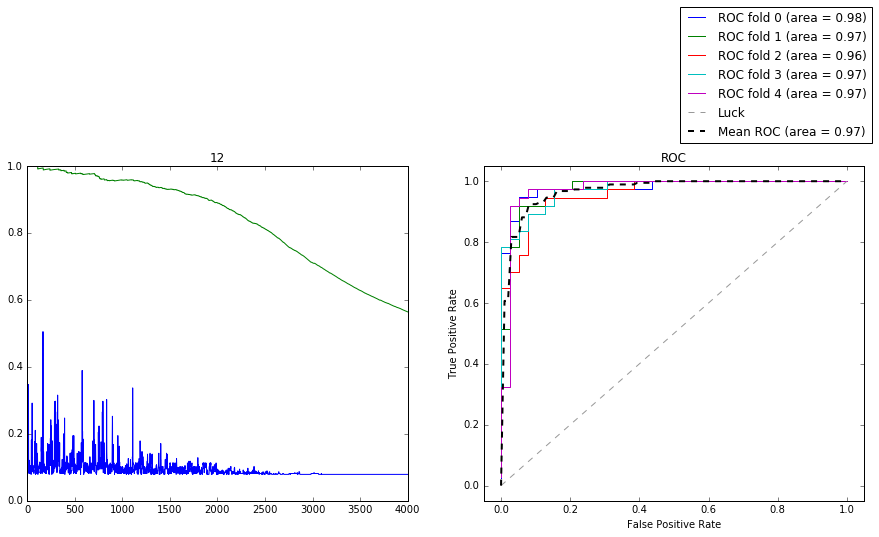

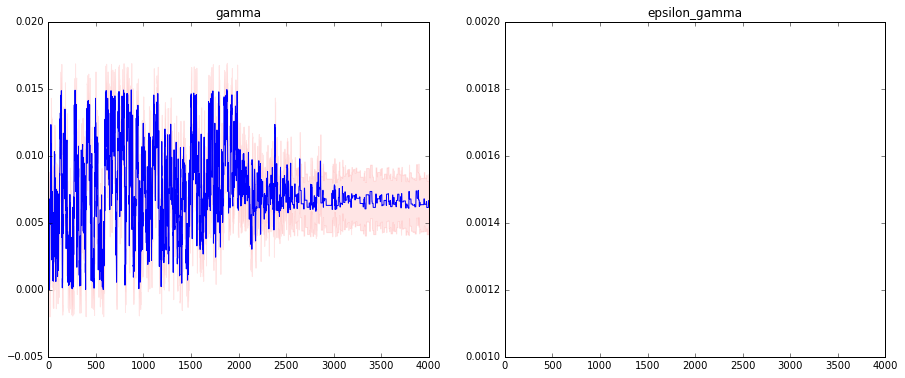

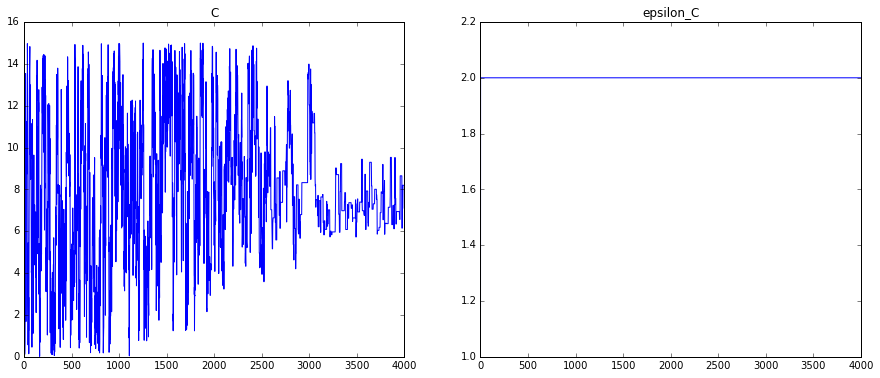

Computing split number:  13
[ 0.8961039   0.8961039   0.92105263  0.93333333  0.97333333]
Accuracy: 0.92 (+/- 0.06)
sensitivity:  0.921052631579 spec:  0.871794871795
sensitivity:  0.947368421053 spec:  0.846153846154
sensitivity:  0.973684210526 spec:  0.868421052632
sensitivity:  0.972972972973 spec:  0.894736842105
sensitivity:  0.972972972973 spec:  0.973684210526
Mean sensitivity is 0.957610241821
Mean specificity is 0.890958164642
230 [120 110]
optimised params
303
CPU times: user 8min 5s, sys: 4min 24s, total: 12min 30s
Wall time: 46min 58s
{'C': 14.828745351356536, 'gmax': (14.625679967395877, 0.0070766003194543846), 'mean_sen': 0.957610241820768, 'err': 0.057173140767338398, 'SV': array([120, 110], dtype=int32), 'gmax_fitness': 0.076014581909318757, 'sen_list': [0.9210526315789473, 0.9473684210526315, 0.9736842105263158, 0.972972972972973, 0.972972972972973], 'spec_list': [0.8717948717948718, 0.8461538461538461, 0.868421052631579, 0.8947368421052632, 0.9736842105263158], 'mean

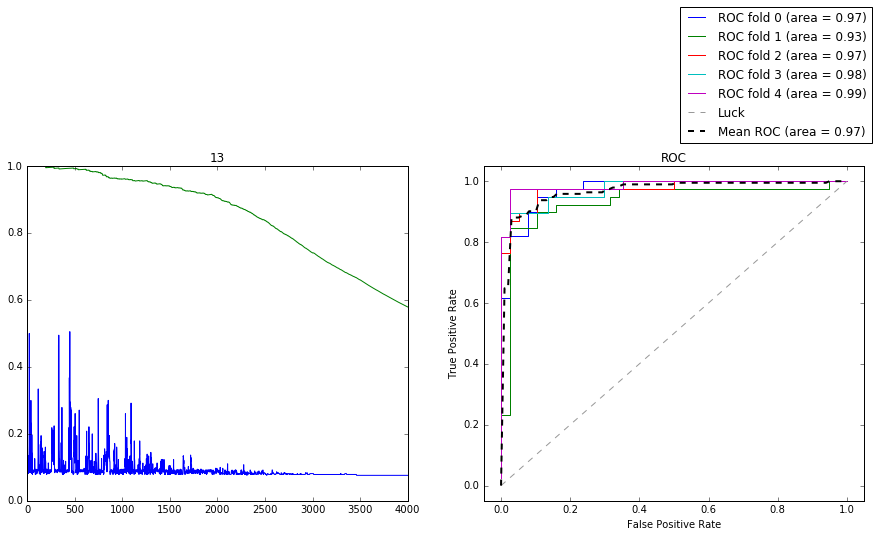

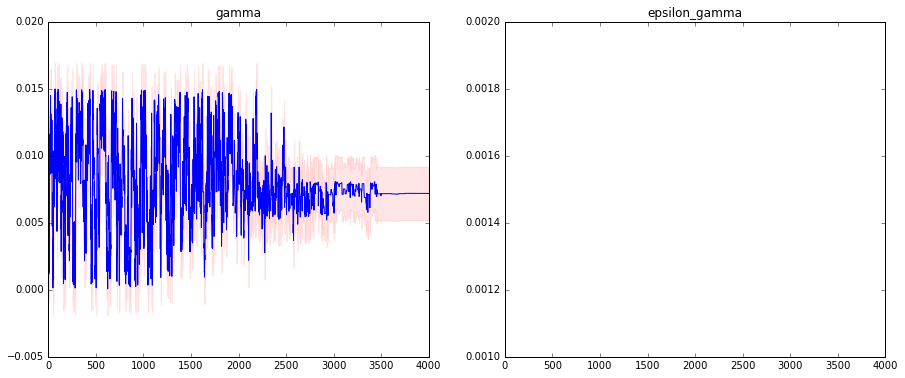

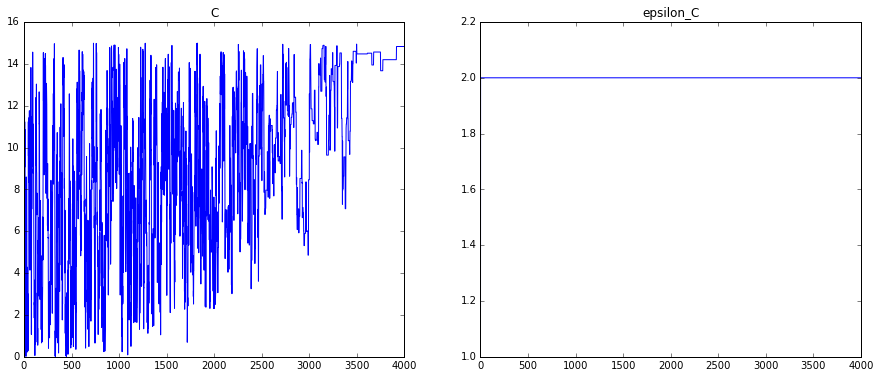

Computing split number:  14
[ 0.8961039   0.94805195  0.90789474  0.96        0.90666667]
Accuracy: 0.92 (+/- 0.05)
sensitivity:  1.0 spec:  0.783783783784
sensitivity:  0.975 spec:  0.918918918919
sensitivity:  0.897435897436 spec:  0.918918918919
sensitivity:  0.948717948718 spec:  0.972222222222
sensitivity:  0.923076923077 spec:  0.888888888889
Mean sensitivity is 0.948846153846
Mean specificity is 0.896546546547
233 [126 107]
optimised params
303
CPU times: user 8min 14s, sys: 4min 23s, total: 12min 38s
Wall time: 47min 3s
{'C': 9.635293332314982, 'gmax': (9.271932098806507, 0.005768894160940337), 'mean_sen': 0.9488461538461539, 'err': 0.050692671445048375, 'SV': array([126, 107], dtype=int32), 'gmax_fitness': 0.0762565504670768, 'sen_list': [1.0, 0.975, 0.8974358974358975, 0.9487179487179487, 0.9230769230769231], 'spec_list': [0.7837837837837838, 0.918918918918919, 0.918918918918919, 0.9722222222222222, 0.8888888888888888], 'mean_spec': 0.8965465465465465, 'gamma': 0.005773606451

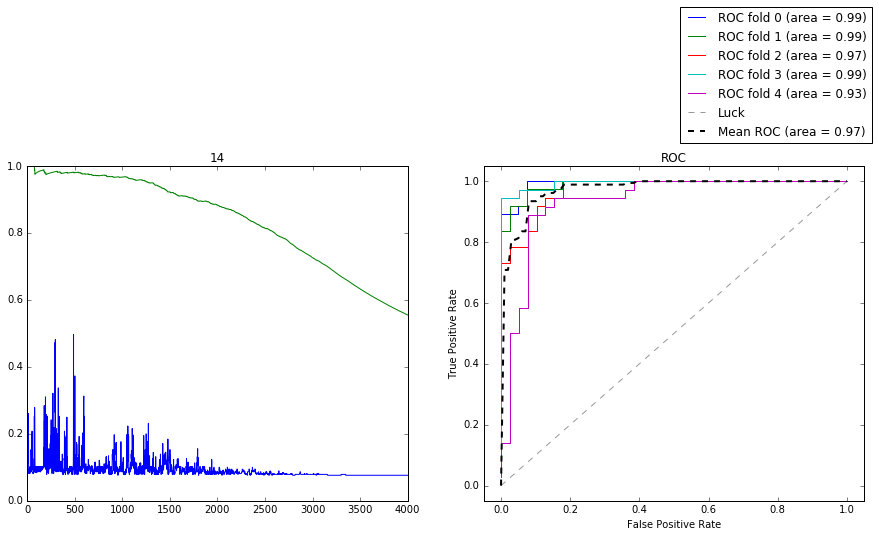

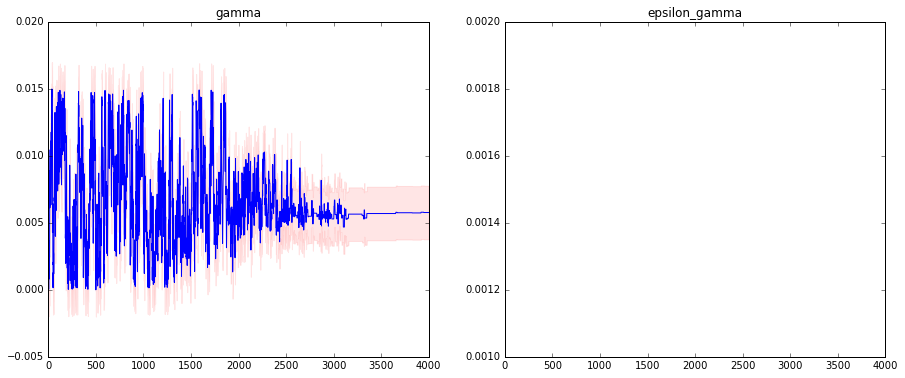

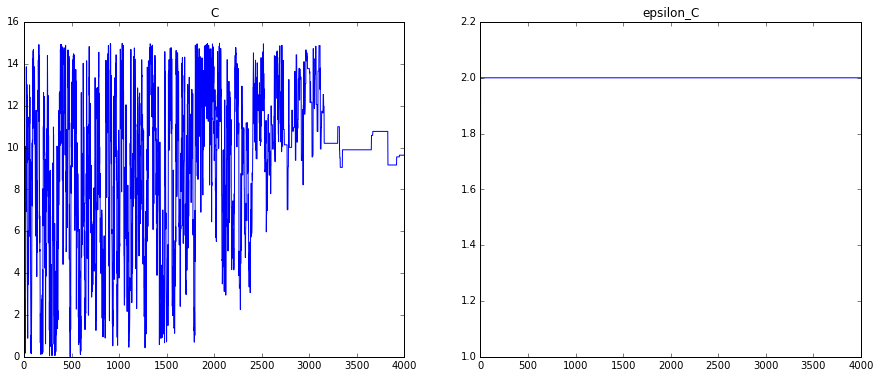

Computing split number:  15
[ 0.93506494  0.93421053  0.90789474  0.89473684  0.86666667]
Accuracy: 0.91 (+/- 0.05)
sensitivity:  0.948717948718 spec:  0.921052631579
sensitivity:  0.974358974359 spec:  0.891891891892
sensitivity:  0.974358974359 spec:  0.837837837838
sensitivity:  0.923076923077 spec:  0.864864864865
sensitivity:  0.868421052632 spec:  0.864864864865
Mean sensitivity is 0.937786774629
Mean specificity is 0.876102418208
238 [131 107]
optimised params
303
CPU times: user 14min 47s, sys: 7min 8s, total: 21min 55s
Wall time: 1h 31min 19s
{'C': 14.23390164312975, 'gmax': (14.679697460624794, 0.0017212334223345512), 'mean_sen': 0.9377867746288798, 'err': 0.051407878147926363, 'SV': array([131, 107], dtype=int32), 'gmax_fitness': 0.09228525860104797, 'sen_list': [0.9487179487179487, 0.9743589743589743, 0.9743589743589743, 0.9230769230769231, 0.868421052631579], 'spec_list': [0.9210526315789473, 0.8918918918918919, 0.8378378378378378, 0.8648648648648649, 0.8648648648648649], 

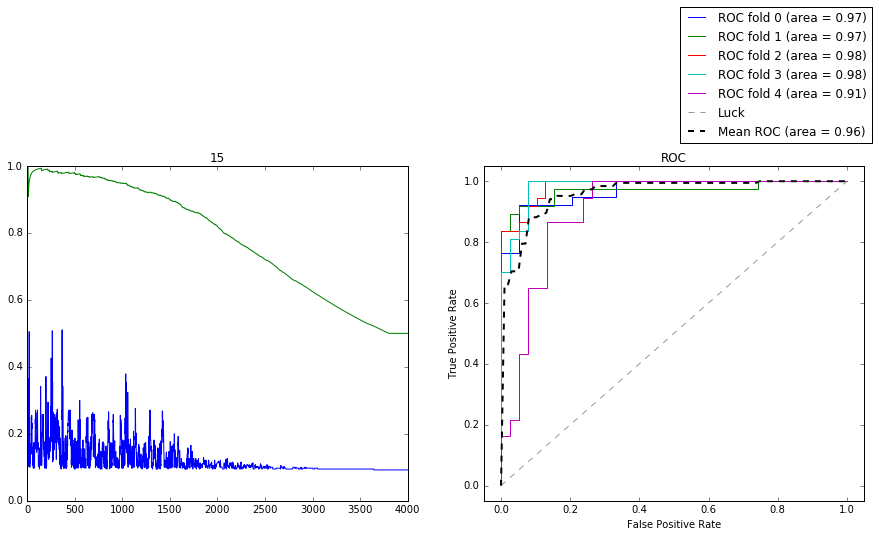

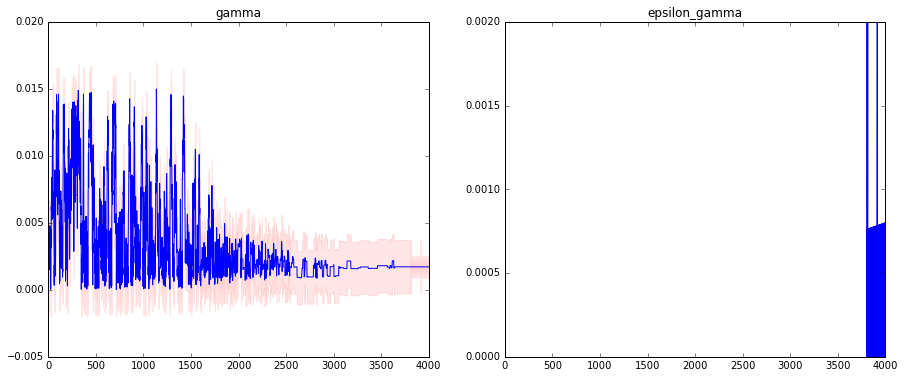

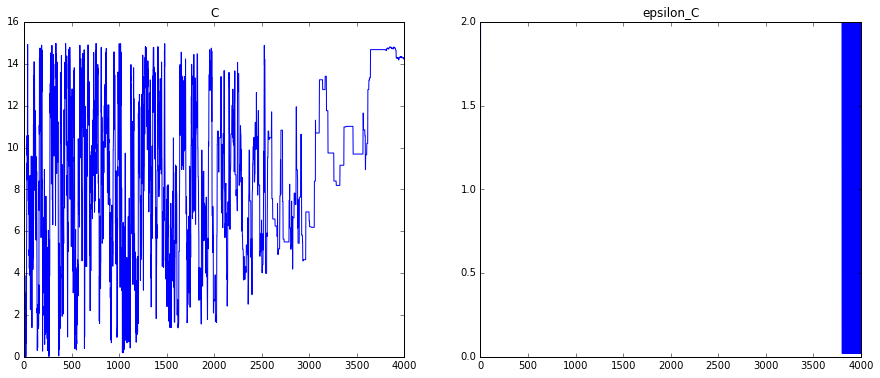

Computing split number:  16
DIDN'T FINISH ON GLOBAL MAXIMUM
[ 0.94805195  0.86842105  0.88157895  0.96052632  0.89333333]
Accuracy: 0.91 (+/- 0.07)
sensitivity:  1.0 spec:  0.894736842105
sensitivity:  0.947368421053 spec:  0.789473684211
sensitivity:  0.947368421053 spec:  0.815789473684
sensitivity:  1.0 spec:  0.921052631579
sensitivity:  0.842105263158 spec:  0.945945945946
Mean sensitivity is 0.947368421053
Mean specificity is 0.873399715505
228 [123 105]
optimised params
303
CPU times: user 18min 30s, sys: 9min 24s, total: 27min 54s
Wall time: 1h 42min 24s
{'C': 6.1177424930772535, 'gmax': (6.1177424930772535, 0.007113480839629165), 'mean_sen': 0.9473684210526315, 'err': 0.073834795980132567, 'SV': array([123, 105], dtype=int32), 'gmax_fitness': 0.089617680565048929, 'sen_list': [1.0, 0.9473684210526315, 0.9473684210526315, 1.0, 0.8421052631578947], 'spec_list': [0.8947368421052632, 0.7894736842105263, 0.8157894736842105, 0.9210526315789473, 0.9459459459459459], 'mean_spec': 0.87

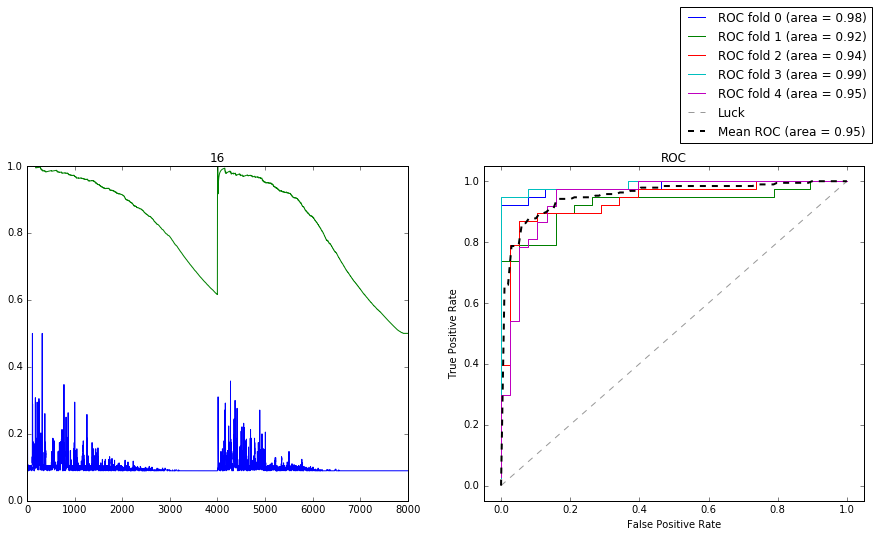

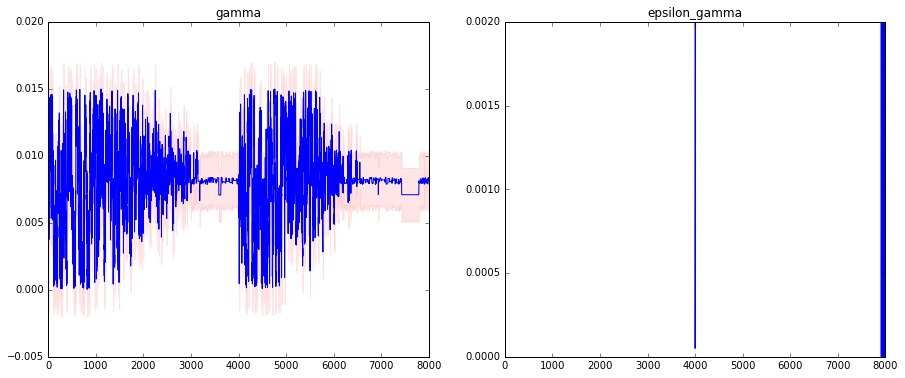

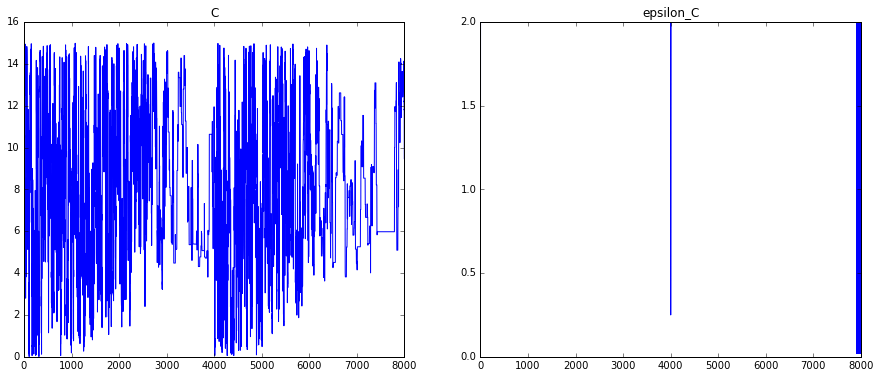

Computing split number:  17
[ 0.89473684  0.89473684  0.92105263  0.89473684  0.93421053]
Accuracy: 0.91 (+/- 0.03)
sensitivity:  0.974358974359 spec:  0.810810810811
sensitivity:  0.897435897436 spec:  0.891891891892
sensitivity:  0.923076923077 spec:  0.918918918919
sensitivity:  0.974358974359 spec:  0.810810810811
sensitivity:  0.974358974359 spec:  0.891891891892
Mean sensitivity is 0.948717948718
Mean specificity is 0.864864864865
234 [131 103]
optimised params
303
CPU times: user 16min 52s, sys: 7min 37s, total: 24min 29s
Wall time: 1h 36min 14s
{'C': 14.757871182427314, 'gmax': (13.944372484892378, 0.006752402489604147), 'mean_sen': 0.9487179487179487, 'err': 0.033287133264930303, 'SV': array([131, 103], dtype=int32), 'gmax_fitness': 0.09210526315789469, 'sen_list': [0.9743589743589743, 0.8974358974358975, 0.9230769230769231, 0.9743589743589743, 0.9743589743589743], 'spec_list': [0.8108108108108109, 0.8918918918918919, 0.918918918918919, 0.8108108108108109, 0.8918918918918919],

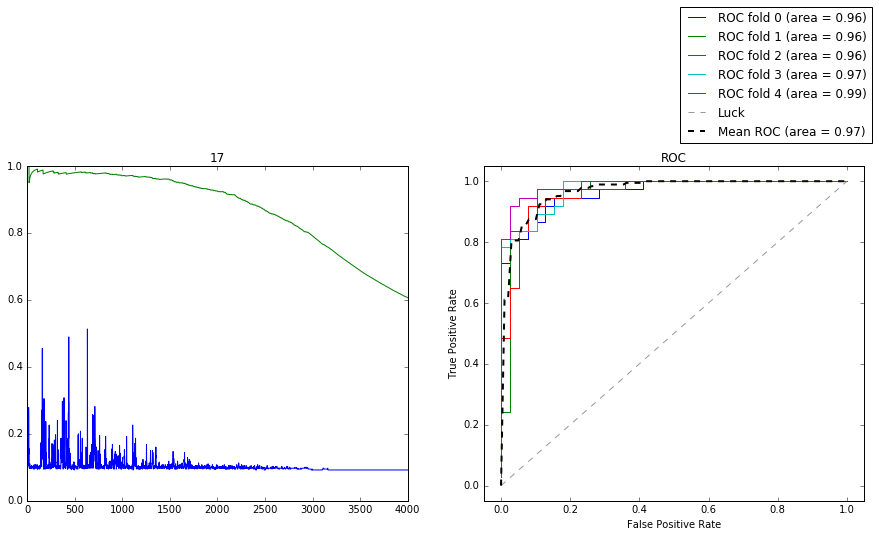

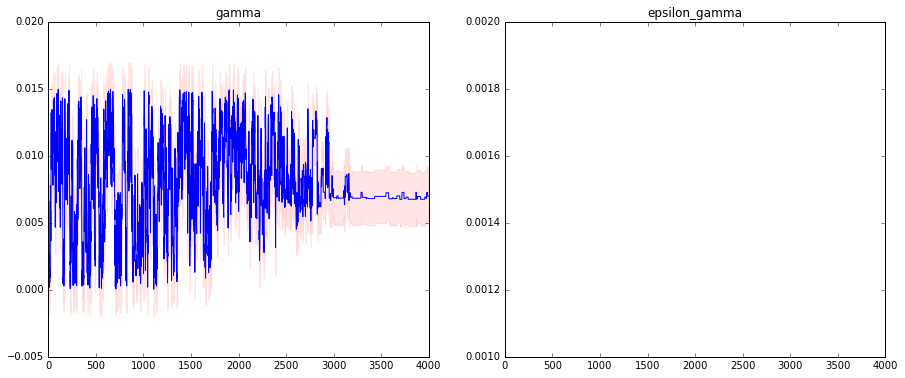

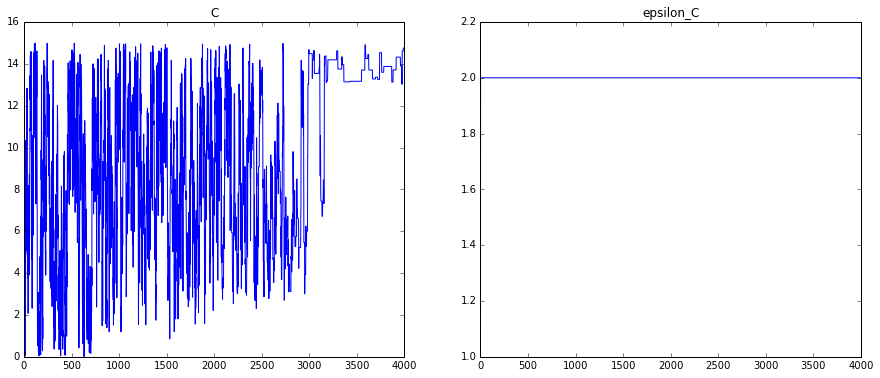

Computing split number:  18
DIDN'T FINISH ON GLOBAL MAXIMUM
[ 0.94736842  0.90789474  0.97368421  0.89473684  0.92105263]
Accuracy: 0.93 (+/- 0.06)
sensitivity:  0.974358974359 spec:  0.918918918919
sensitivity:  0.974358974359 spec:  0.837837837838
sensitivity:  1.0 spec:  0.945945945946
sensitivity:  0.923076923077 spec:  0.864864864865
sensitivity:  0.974358974359 spec:  0.864864864865
Mean sensitivity is 0.969230769231
Mean specificity is 0.886486486486
256 [140 116]
optimised params
303
CPU times: user 34min 15s, sys: 15min 10s, total: 49min 26s
Wall time: 3h 16min 30s
{'C': 5.800496068867872, 'gmax': (5.800496068867872, 0.010358393769921627), 'mean_sen': 0.9692307692307693, 'err': 0.056685945338257923, 'SV': array([140, 116], dtype=int32), 'gmax_fitness': 0.071052631578947256, 'sen_list': [0.9743589743589743, 0.9743589743589743, 1.0, 0.9230769230769231, 0.9743589743589743], 'spec_list': [0.918918918918919, 0.8378378378378378, 0.9459459459459459, 0.8648648648648649, 0.864864864864

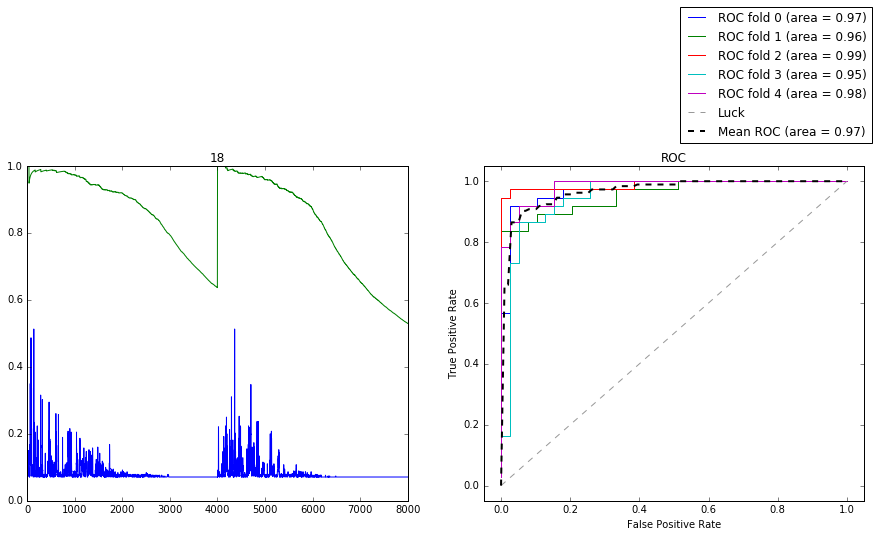

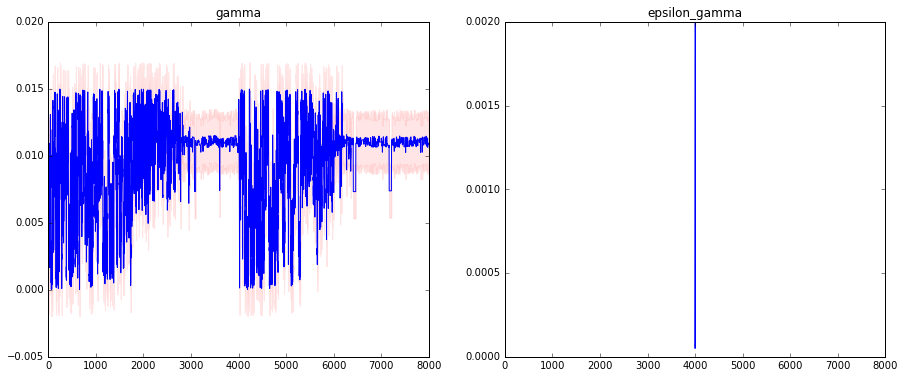

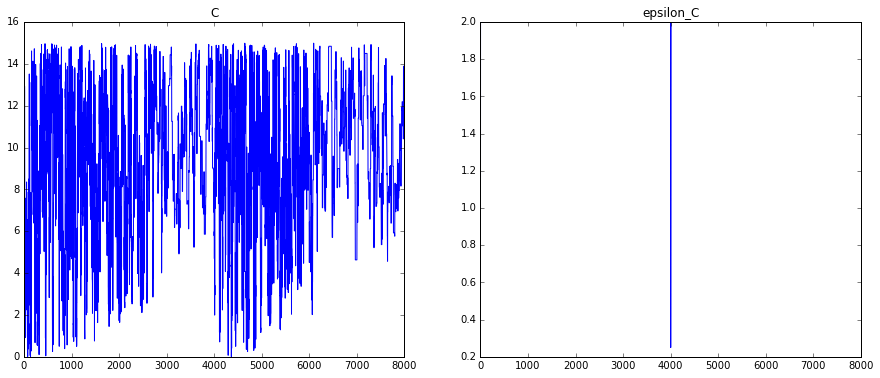

Computing split number:  19
[ 0.93506494  0.89473684  0.94736842  0.90789474  0.88      ]
Accuracy: 0.91 (+/- 0.05)
sensitivity:  0.897435897436 spec:  0.973684210526
sensitivity:  1.0 spec:  0.789473684211
sensitivity:  1.0 spec:  0.894736842105
sensitivity:  0.921052631579 spec:  0.894736842105
sensitivity:  0.921052631579 spec:  0.837837837838
Mean sensitivity is 0.947908232119
Mean specificity is 0.878093883357
215 [117  98]
optimised params
303
CPU times: user 17min 45s, sys: 7min 43s, total: 25min 28s
Wall time: 1h 35min 47s
{'C': 6.458603756752128, 'gmax': (7.270793144672839, 0.005994129199109539), 'mean_sen': 0.9479082321187583, 'err': 0.049933199616749413, 'SV': array([117,  98], dtype=int32), 'gmax_fitness': 0.086987012987012946, 'sen_list': [0.8974358974358975, 1.0, 1.0, 0.9210526315789473, 0.9210526315789473], 'spec_list': [0.9736842105263158, 0.7894736842105263, 0.8947368421052632, 0.8947368421052632, 0.8378378378378378], 'mean_spec': 0.8780938833570413, 'gamma': 0.0061979

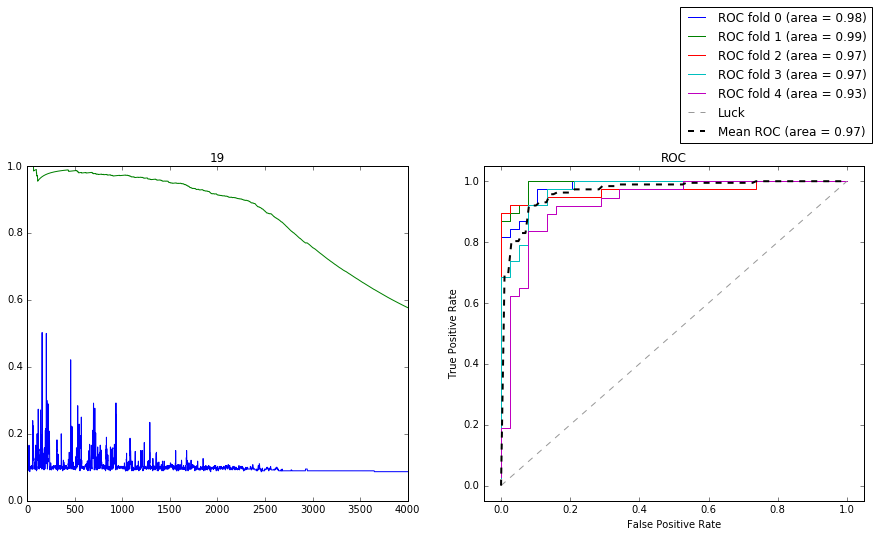

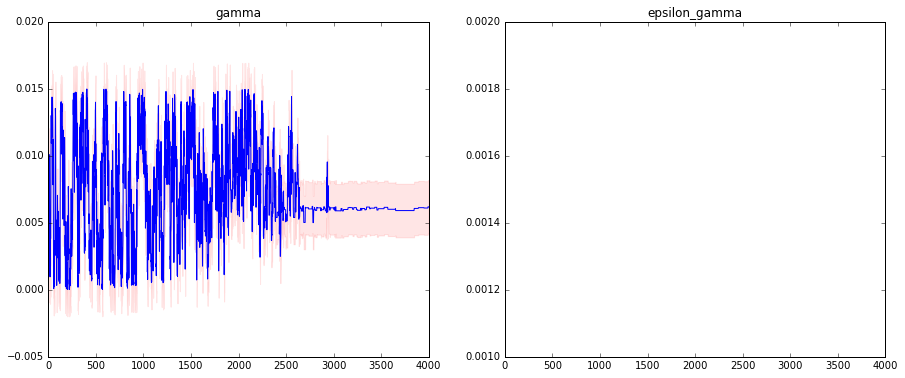

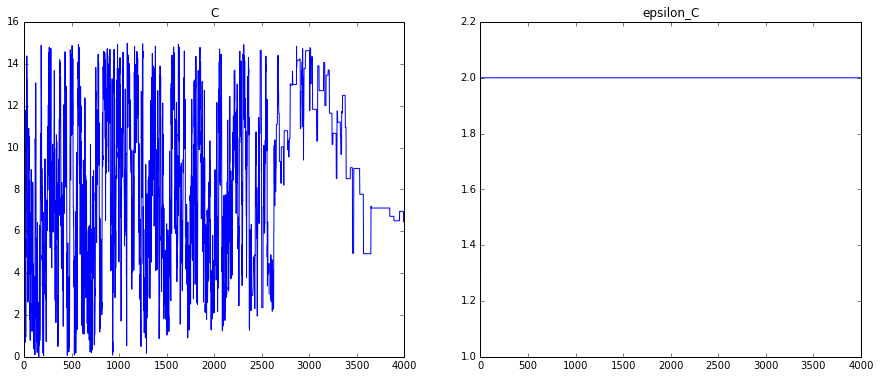

In [46]:
#results = []
#results = results[:11]
for i, data in enumerate(dataset):
    if i>=12:
        print "Computing split number: ", i
        %time clf, step_list, lc_dict, roc_dict, hyp_dict = learn(data['train_X'], data['train_y'],init_range=[1, 0.001], n_folds=5, n_jobs=7)
        result = {'Split':i, 'clf':clf, 'step_list':step_list, 'learning_curve':lc_dict, 
                  'roc_dict':roc_dict, 'hyp_dict':hyp_dict}
        results.append(result)
        print hyp_dict
        plot_result(result)
        sys.stdout.flush()
    
    

## Save results

In [109]:
#np.save('results_p-20.npy', results)
#np.save('dataset_p-20.npy', dataset)

## Load results

In [110]:
#results = np.load('results_p-20.npy')
#dataset = np.load('dataset_p-20.npy')

In [64]:
def plot_result(result):
    lc_dict = result['learning_curve']
    roc_dict = result['roc_dict']
    hyp_dict = result['hyp_dict']
    step_list = result['step_list']
    print 'gmax_fitness', hyp_dict['gmax_fitness']
    fitness = [step_dict['fitness'] for step_dict in step_list]
    frac_acc = [step_dict['frac_acc'] for step_dict in step_list]
    C = np.asarray([step_dict['C'] for step_dict in step_list[1:]])
    gamma = np.asarray([step_dict['gamma'] for step_dict in step_list[1:]])
    eps_gamma = np.asarray([step_dict['epsilon_gamma'] for step_dict in step_list[1:]])
    eps_C = np.asarray([step_dict['epsilon_C'] for step_dict in step_list[1:]])
    print "final fitness", fitness[-1]
    #plt.figure(figsize=(10,6))
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
    ax1.set_title(str(result['Split']))
    ax1.plot(fitness)
    ax1.plot(frac_acc)
    ax2.set_title("ROC")
    ax2 = ROC_plot(ax2, roc_dict)

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

    ax1.fill_between(range(len(gamma)),gamma - eps_gamma,
                     gamma + eps_gamma, alpha=0.1,color="r")

    ax1.set_title('gamma')
    ax1.plot(gamma)
    ax2.set_title('epsilon_gamma')
    ax2.plot(eps_gamma)
    plt.show()

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
    ax1.set_title('C')
    ax1.plot(C)
    ax2.set_title('epsilon_C')
    ax2.plot(eps_C)
    plt.show()
        

def ROC_plot(ax, roc_dict):
    pr_lst = roc_dict['pr_lst']
    mean_tpr = roc_dict['mean_tpr']
    mean_fpr = roc_dict['mean_fpr']
    mean_auc = roc_dict['mean_auc']
    for i, (fpr,tpr,roc_auc) in enumerate(pr_lst):
        ax.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    ax.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    ax.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    #ax.set_title(" $\gamma$ = " + str(gamma) + " C = " + str(C) + " #SV = " + str(sum(SV)))
    ax.legend(loc='best', bbox_to_anchor=(0.5, 1.05))
    
    return ax

def internalCV_score(results):
    print "Internal CV results"
    accuracy_list = []
    sens_list = []
    spec_list = []
    params = ['accuracy', 'err', 'SV', 'C', 'gamma','gmax_fitness','mean_sen','mean_spec']
    for result in results:
        hyp_dict = result['hyp_dict']
        print hyp_dict
        #for key in params:
            #print key
            #print hyp_dict[key]
        accuracy_list.append(hyp_dict['accuracy'])
        sens_list.append(hyp_dict['mean_sen'])
        spec_list.append(hyp_dict['mean_spec'])

    
    print "mean accuracy", np.mean(accuracy_list)
    print "mean sensitivity", np.mean(sens_list)
    print "mean specifity", np.mean(spec_list)
    

def externalCV_score(results, dataset): 
    """Val_X and Val_y are lists of test data.
    """
    #print "External results" 
    avg_score = []
    avg_sn = []
    avg_sp = []
    for i, result in enumerate(results):
        clf = result['clf']
        test_X = dataset[i]['test_X']
        test_y = dataset[i]['test_y'] 
        train_y = dataset[i]['train_y']
        score = clf.score(test_X, test_y)
        print "test score ", i,": ", score
        #print "Patient to Healthy Ratio of test set: " 
        #P2Hratio(test_y)
        #print "Patient to Healthy Ratio of train set: " 
        #P2Hratio(train_y)
        
        avg_score.append(score)
        y_pred = clf.predict(test_X)
        cm = confusion_matrix(test_y, y_pred)              
        tn = float(cm[0][0])/np.sum(cm[0])
        tp = float(cm[1][1])/np.sum(cm[1])
        print "sensitivity: ", tn, "spec: ", tp
        avg_sn.append(tn)
        avg_sp.append(tp)
    print "average score: ", np.mean(avg_score)
    print "average sensitivity: ", np.mean(avg_sn)
    print "average specificity: ", np.mean(avg_sp)
    
         
def externalCV_plot(results, dataset):
    pop_tpr = []
    pop_fpr = []
    pop_auc = []
    for result in results:
        roc_dict = result['roc_dict']
        pop_tpr.append(roc_dict['mean_tpr'])
        pop_fpr.append(roc_dict['mean_fpr'])
        pop_auc.append(roc_dict['mean_auc'])
        
    fig, (ax) = plt.subplots(1, figsize=(15,6))
    ax.set_title("ROC internal")
    #ax = ROC_plot(ax1, roc_dict)
    
    
    for i, (tpr) in enumerate(pop_tpr):
        
        ax.plot(pop_fpr[i], tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, pop_auc[i]))

    ax.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    ax.plot(np.mean(pop_fpr, axis=0), np.mean(pop_tpr, axis=0), 'k--',
         label='Mean ROC (area = %0.2f)' % np.mean(pop_auc), lw=2)

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    #ax.set_title(" $\gamma$ = " + str(gamma) + " C = " + str(C) + " #SV = " + str(sum(SV)))
    ax.legend(loc='best', bbox_to_anchor=(0.5, 1.05))
    
    
    fig, (ax) = plt.subplots(1, figsize=(15,6))
    ax.set_title("ROC external")
    mean_tpr = 0.0
    mean_fpr = np.linspace(0,1,100)
    all_tpr =[]
    pr_lst = []
    for i, result in enumerate(results):
        clf = result['clf']
        test_X = dataset[i]['test_X']
        test_y = dataset[i]['test_y'] 
        train_X = dataset[i]['train_X']
        train_y = dataset[i]['train_y']
        probas_ = clf.fit(train_X, train_y).predict_proba(test_X)
        fpr, tpr, thresholds = roc_curve(test_y, probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr) 
        pr_lst.append([fpr, tpr, roc_auc])
    mean_tpr /= len(results)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    for i, (fpr, tpr, roc_auc) in enumerate(pr_lst):
        ax.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    
    ax.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    ax.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    #ax.set_title(" $\gamma$ = " + str(gamma) + " C = " + str(C) + " #SV = " + str(sum(SV)))
    ax.legend(loc='best', bbox_to_anchor=(0.5, 1.05))
    
    
def ROC_data(X, y, clf, cv):
    mean_tpr = 0.0
    mean_fpr = np.linspace(0,1,100)
    all_tpr =[]
    pr_lst = []
    
    for i, (train, test) in enumerate(cv):
        probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr) 
        pr_lst.append([fpr, tpr, roc_auc])
        
    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    
    return pr_lst, mean_tpr, mean_fpr, mean_auc

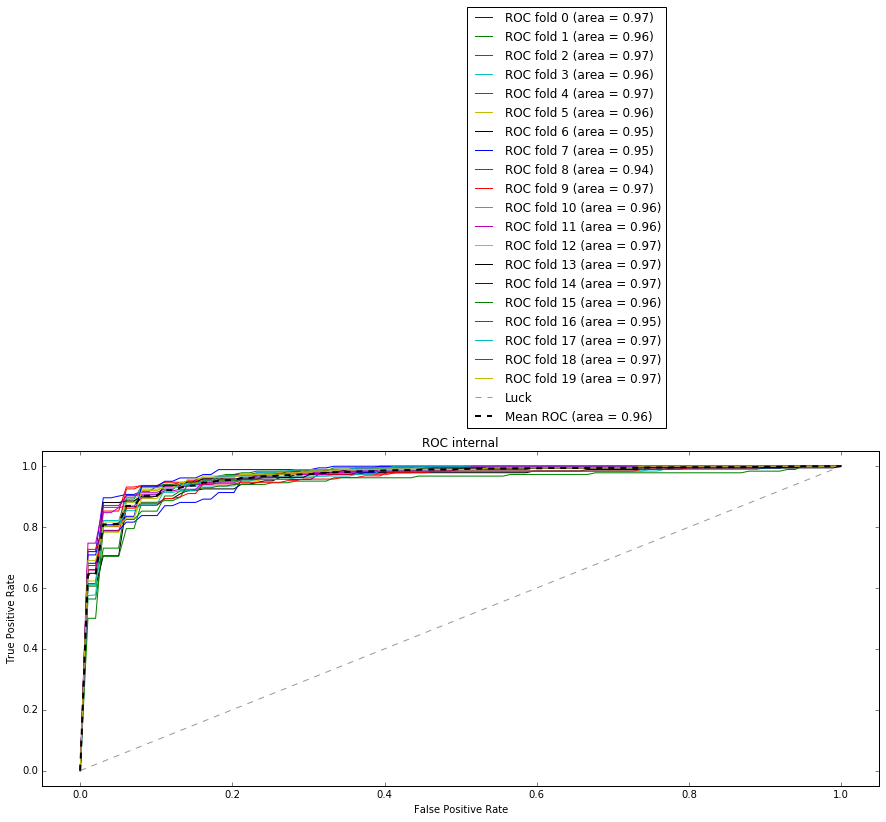

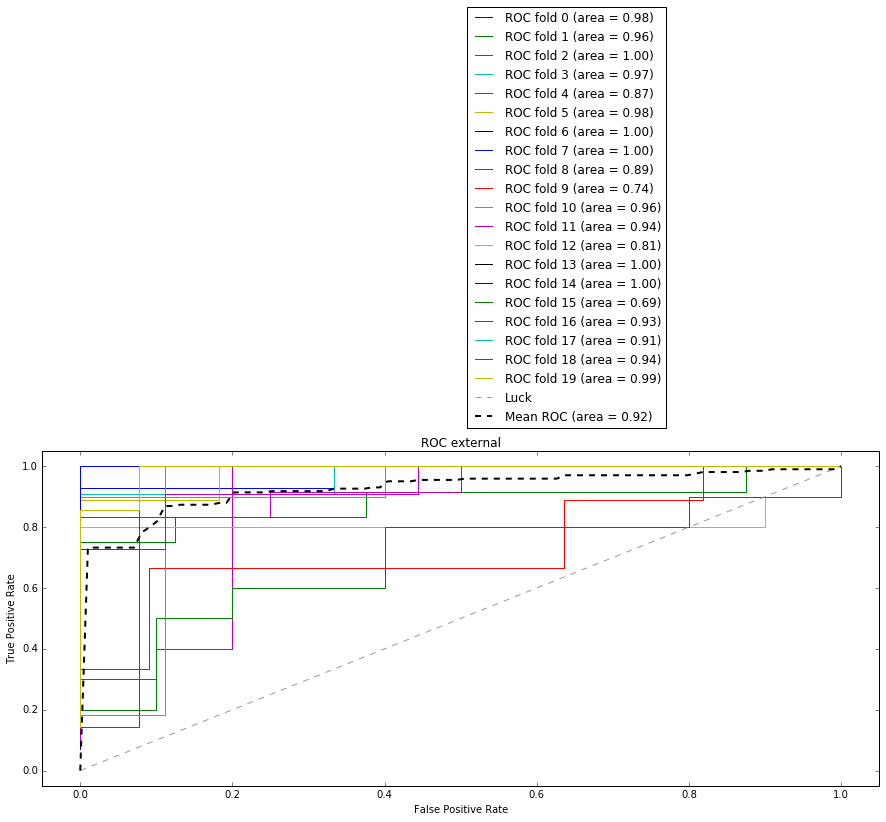

In [63]:
externalCV_plot(results, dataset)

In [65]:
#    n_accepted = 0.0 #1
#    epsilon_C_min = 0.02
#    epsilon_C_max = 2
#    epsilon_gamma_min = 1e-7 
#    epsilon_gamma_max = 0.002
#    fraction_acc_ideal = 0.5
#    fraction_acc = 0.0
#    C_max = 15
#    gamma_max = 0.015
externalCV_score(results, dataset)

test score  0 :  0.75
sensitivity:  1.0 spec:  0.642857142857
test score  1 :  0.85
sensitivity:  1.0 spec:  0.7
test score  2 :  0.8
sensitivity:  1.0 spec:  0.333333333333
test score  3 :  0.65
sensitivity:  1.0 spec:  0.363636363636
test score  4 :  0.85
sensitivity:  0.8 spec:  0.9
test score  5 :  0.65
sensitivity:  1.0 spec:  0.222222222222
test score  6 :  0.9
sensitivity:  1.0 spec:  0.777777777778
test score  7 :  0.8
sensitivity:  1.0 spec:  0.636363636364
test score  8 :  0.75
sensitivity:  1.0 spec:  0.583333333333
test score  9 :  0.7
sensitivity:  1.0 spec:  0.333333333333
test score  10 :  0.8
sensitivity:  1.0 spec:  0.6
test score  11 :  0.75
sensitivity:  1.0 spec:  0.583333333333
test score  12 :  0.75
sensitivity:  1.0 spec:  0.5
test score  13 :  1.0
sensitivity:  1.0 spec:  1.0
test score  14 :  0.65
sensitivity:  1.0 spec:  0.461538461538
test score  15 :  0.55
sensitivity:  0.2 spec:  0.9
test score  16 :  0.75
sensitivity:  0.923076923077 spec:  0.428571428571


# Visualise MC search

In [73]:
from sklearn.grid_search import GridSearchCV #optimizing gamma and c

In [116]:
p = 0
clf = results[p]['clf']
CV = cross_validation.StratifiedKFold(dataset[p]['train_y'], n_folds=5, shuffle = True)
c_max = 15
gamma_max = 0.015
c_res = 64
gamma_res = 64
gamma_range = np.linspace(0.000001, gamma_max, 64)
c_range = np.linspace(0.01, c_max, 64)
param_grid = dict(gamma = gamma_range, C = c_range)

grid = GridSearchCV(clf, param_grid, cv=CV, scoring="accuracy", n_jobs=7)

%time grid.fit(dataset[p]['train_X'], dataset[p]['train_y'])

CPU times: user 2min 26s, sys: 3.52 s, total: 2min 29s
Wall time: 29min 34s


GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[0 1 ..., 0 1], n_folds=5, shuffle=True, random_state=None),
       error_score='raise',
       estimator=SVC(C=6.51188802361, cache_size=3000, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.00539785165933,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=7,
       param_grid={'C': array([  1.00000e-02,   2.47937e-01,   4.85873e-01,   7.23810e-01,
         9.61746e-01,   1.19968e+00,   1.43762e+00,   1.67556e+00,
         1.91349e+00,   2.15143e+00,   2.38937e+00,   2.62730e+00,
         2.86524e+00,   3.10317e+00,   3.34111e+00,   3.57905e+00,
         3.8169...,   1.38096e-02,   1.40477e-02,
         1.42858e-02,   1.45238e-02,   1.47619e-02,   1.50000e-02])},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [120]:
print grid.best_params_
print grid.best_score_
print 1-results[p]['hyp_dict']['gmax_fitness']

{'C': 4.7687301587301585, 'gamma': 0.0061910634920634925}
0.921052631579
0.931638186375


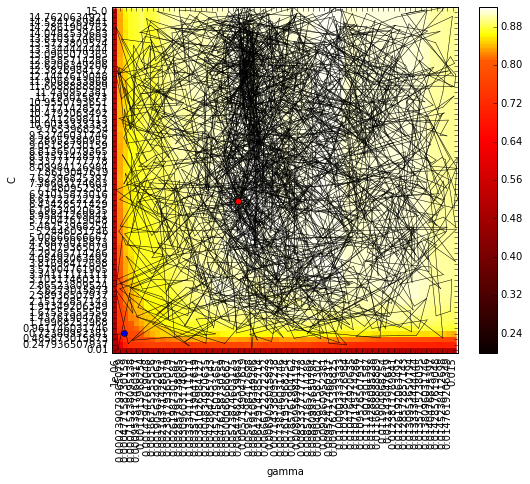

In [121]:
fig = plot_gridsearch(grid, c_range, gamma_range)
plot_traj(fig, results[p]['step_list'][0:], gamma_max, c_max, 64, 64)

plt.show()

## 24x40 gridsearch

In [102]:
print grid.best_params_
print grid.best_score_

{'C': 5.2239130434782606, 'gamma': 0.006923615384615384}
0.913157894737


In [108]:
1-results[p]['hyp_dict']['gmax_fitness']

0.93163818637502838

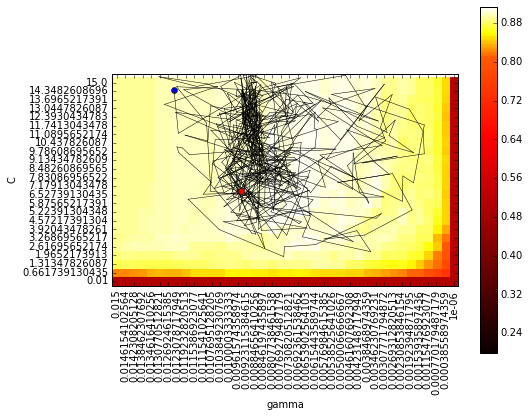

In [101]:
fig = plot_gridsearch(grid, c_range, gamma_range)
plot_traj(fig, results[p]['step_list'][2000:], 0.015, 15, 40, 24)

plt.show()

In [111]:
def plot_gridsearch(grid, c_range, gamma_range):
    scores = [x[1] for x in grid.grid_scores_]
    scores = np.array(scores).reshape(len(c_range), len(gamma_range))

    np.save('gridsearchscores_p-20_64x64.npy', scores)

    class MidpointNormalize(Normalize):

        def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
            self.midpoint = midpoint
            Normalize.__init__(self, vmin, vmax, clip)

        def __call__(self, value, clip=None):
            x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
            return np.ma.masked_array(np.interp(value, x, y))

    fig = plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.81),origin='lower')#, extent=[0,len(gamma_range),0,len(c_range)])
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    
    plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=90)
    plt.yticks(np.arange(len(c_range)), c_range)
    
    return fig

def plot_traj(fig, step_list, gamma_range, c_range, gamma_res, c_res):
    #fig=plt.figure()
    
    C_p = (step_list[0]['C']/c_range)*c_res
    gamma_p = (step_list[0]['gamma']/gamma_range)*gamma_res
    plt.plot(gamma_p, C_p, 'bo')

    for step_dict in step_list:
        C = (step_dict['C']/c_range)*c_res
        gamma = (step_dict['gamma']/gamma_range)*gamma_res
        #print C, gamma

        plt.plot([gamma_p, gamma],[C_p, C], 'k-', lw=0.5)

        C_p = C
        gamma_p = gamma

    plt.plot(gamma_p, C_p, 'ro') 
    return fig

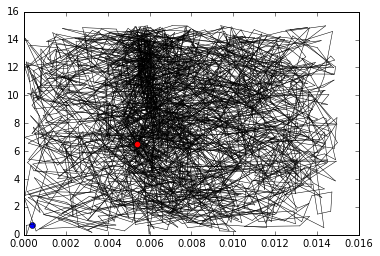

In [72]:
fig = plt.figure()
plot_traj(fig, results[0]['step_list'])
plt.show()

# Visualise learning surface

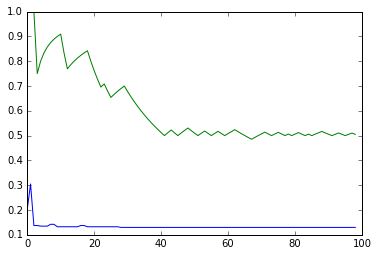

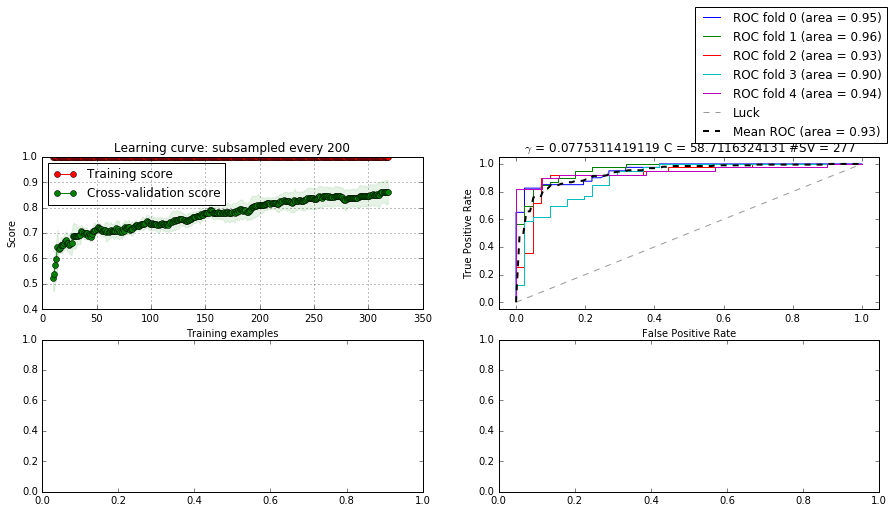

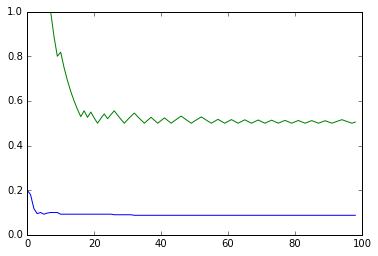

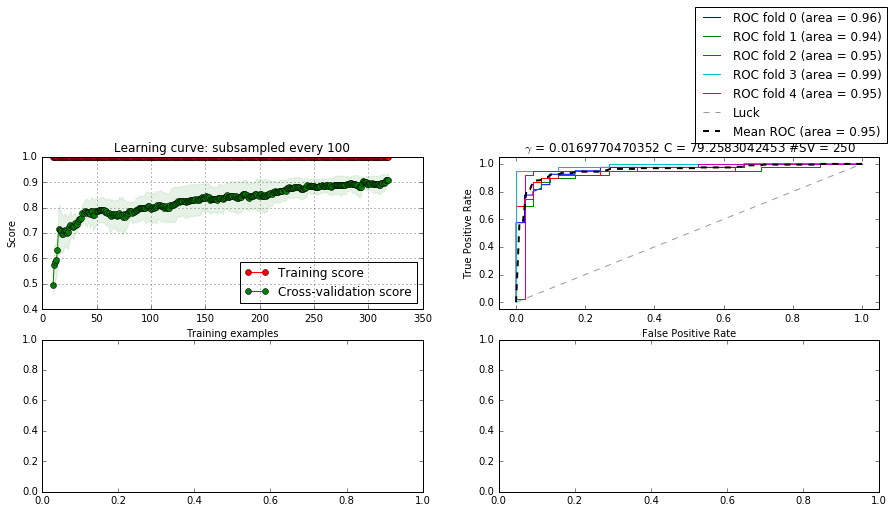

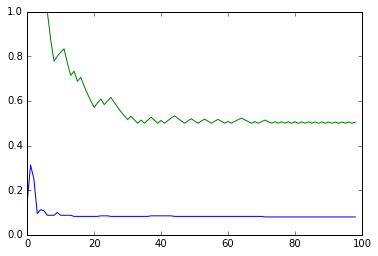

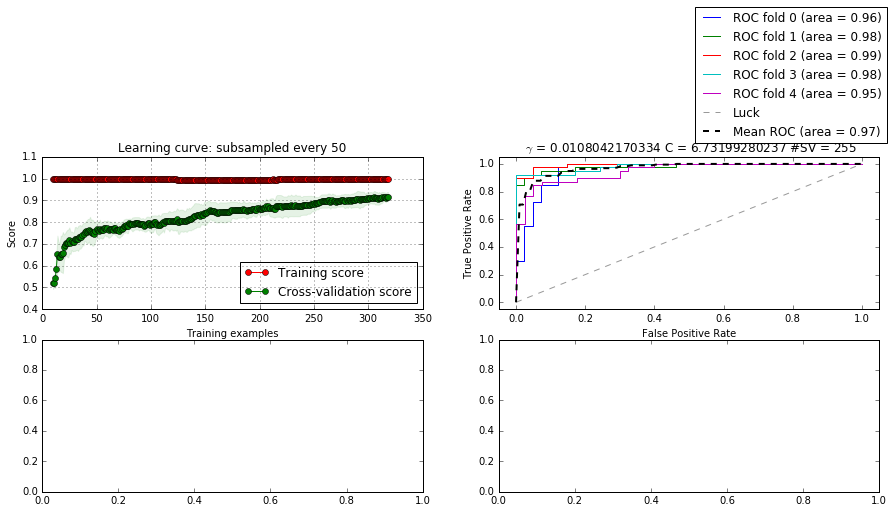

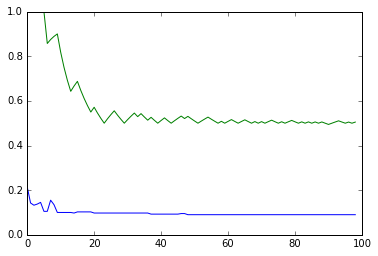

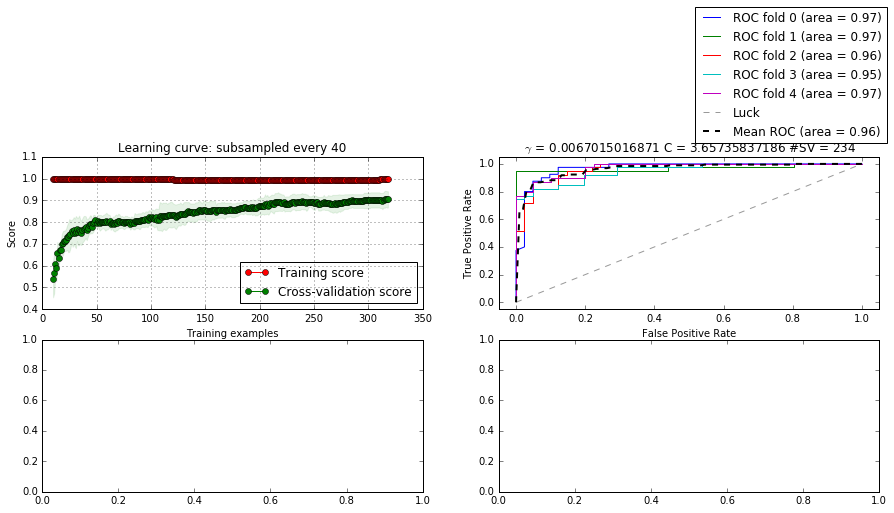

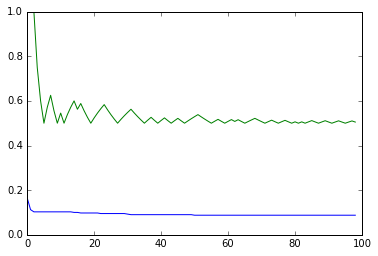

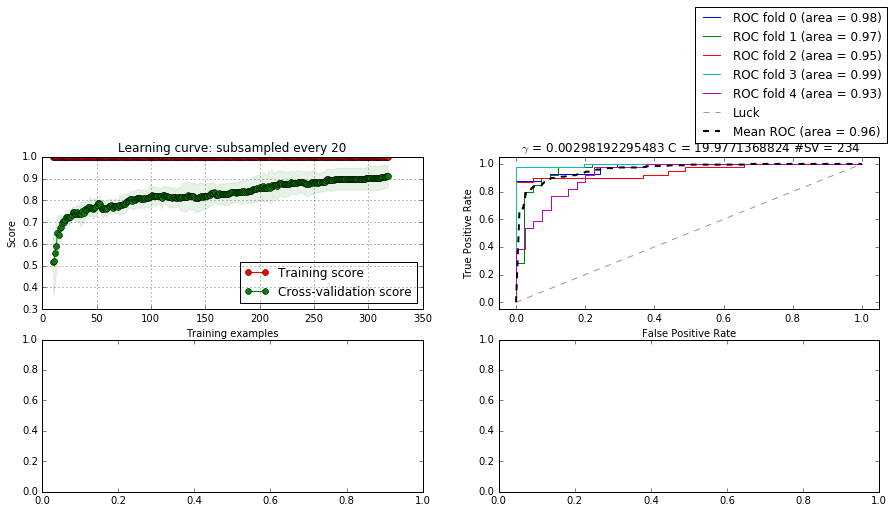

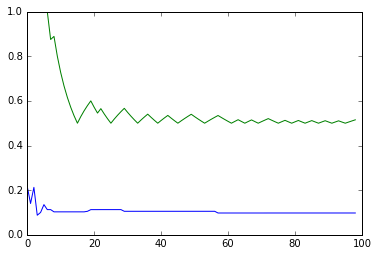

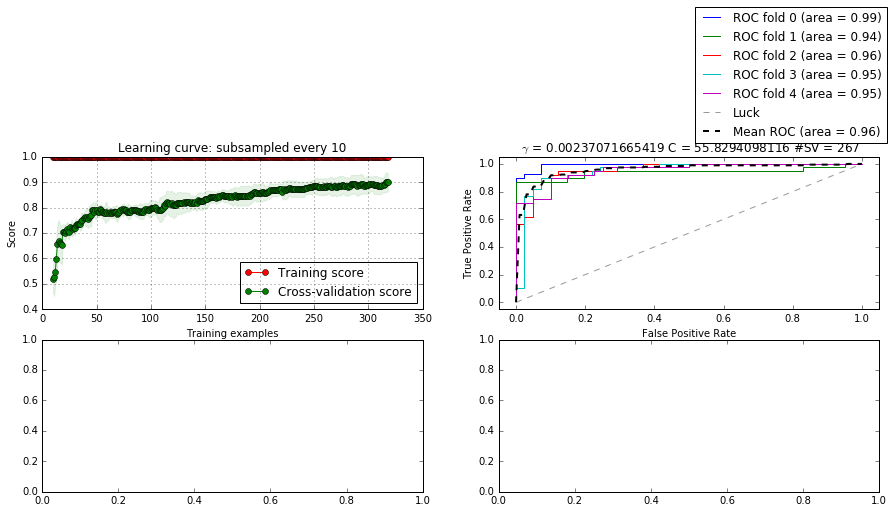

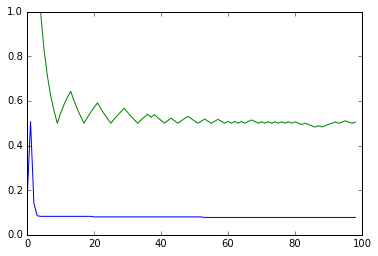

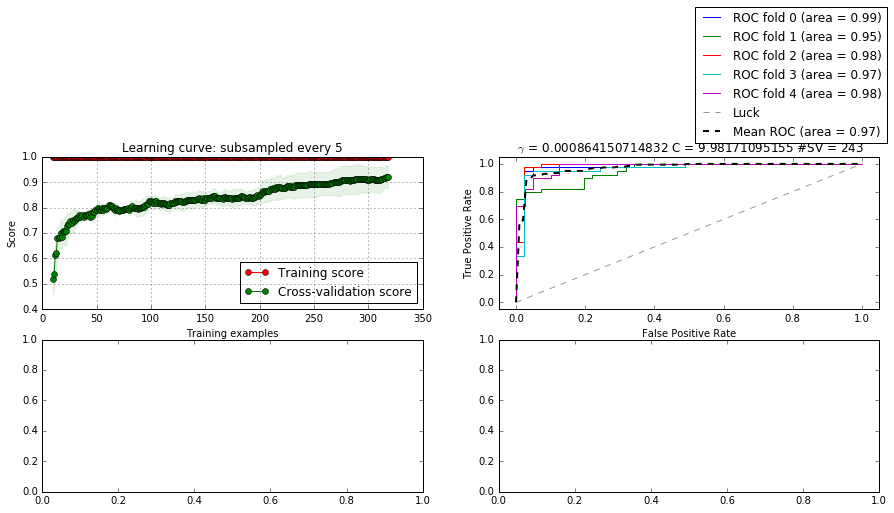

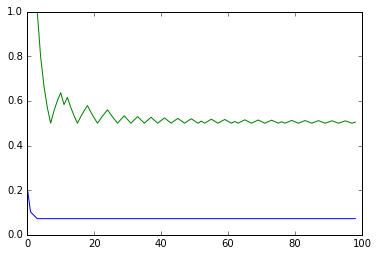

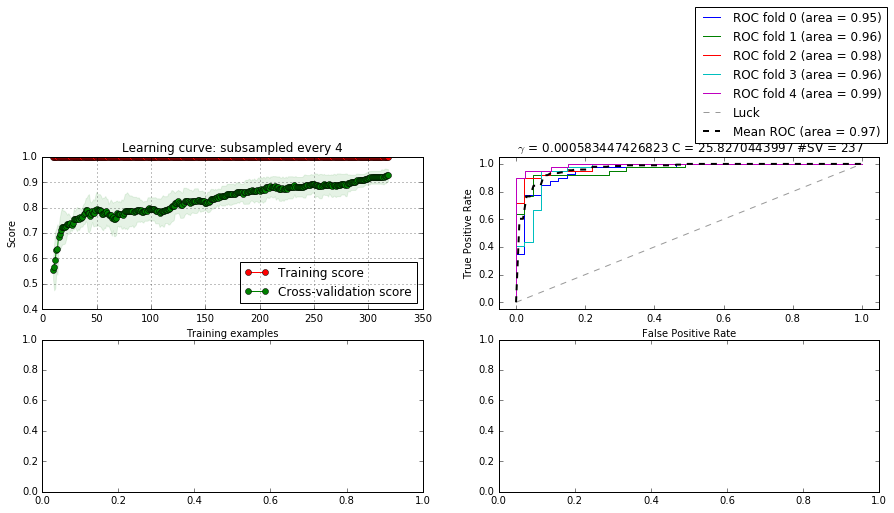

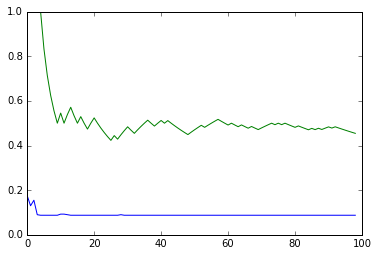

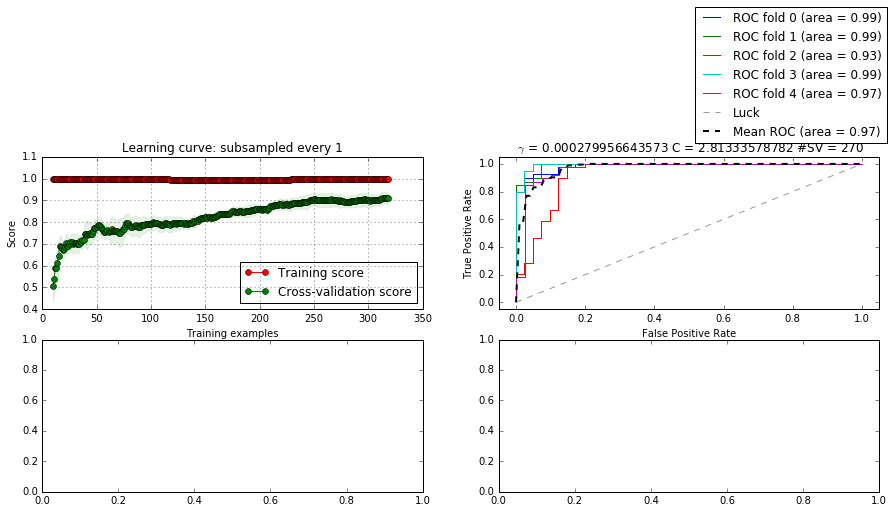

In [59]:
for i, sample in enumerate(learning_surface):
    #print sample
    
    lc_dict = sample['learning_curve']
    roc_dict = sample['roc_dict']
    hyp_dict = sample['hyp_dict']
    step_list = sample['step_list']
    fitness = [step_dict['fitness'] for step_dict in step_list]
    frac_acc = [step_dict['frac_acc'] for step_dict in step_list]
    plt.figure()
    #plt.title()
    plt.plot(fitness)
    plt.plot(frac_acc)
    plot_learning_curve(lc_dict, roc_dict, hyp_dict, step_list, "Learning curve: subsampled every "+str(sample['sub_level']), ylim=None)

9 309
(9, 309)
9 309
(9, 309)


<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

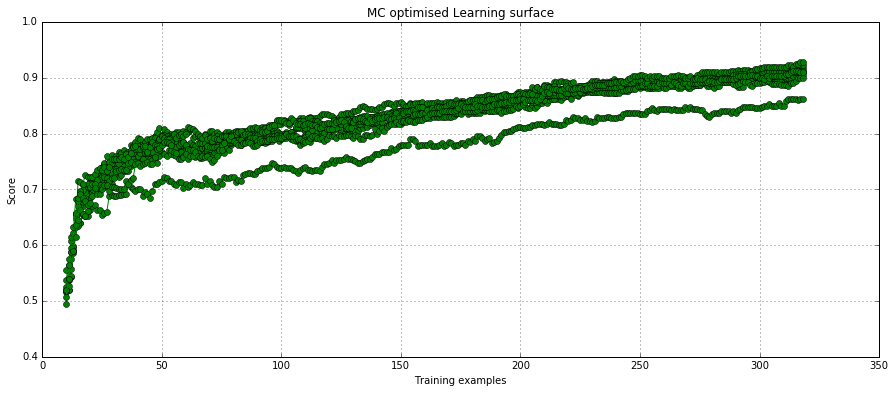

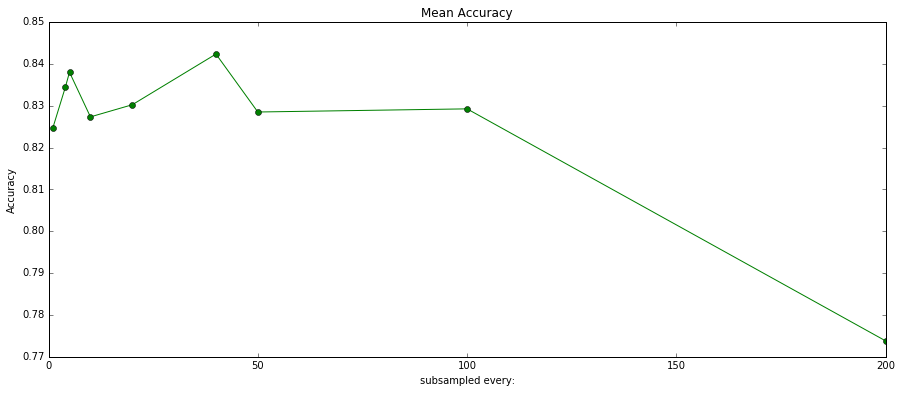

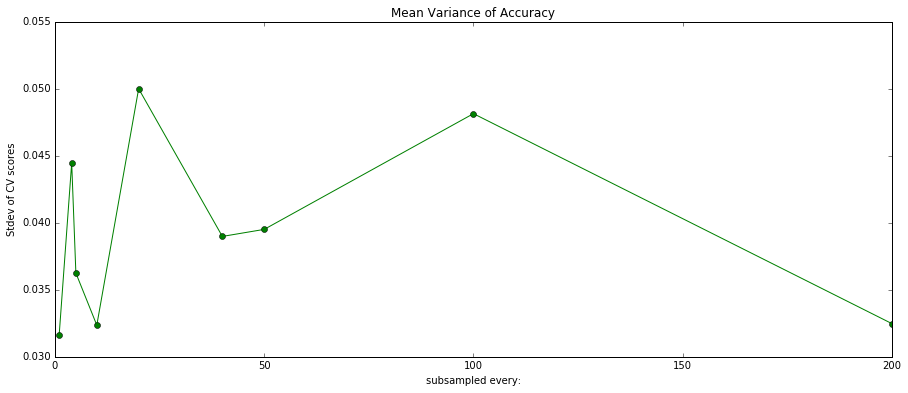

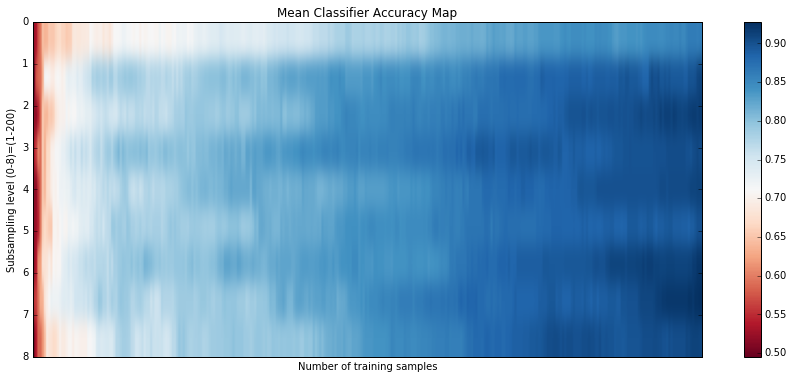

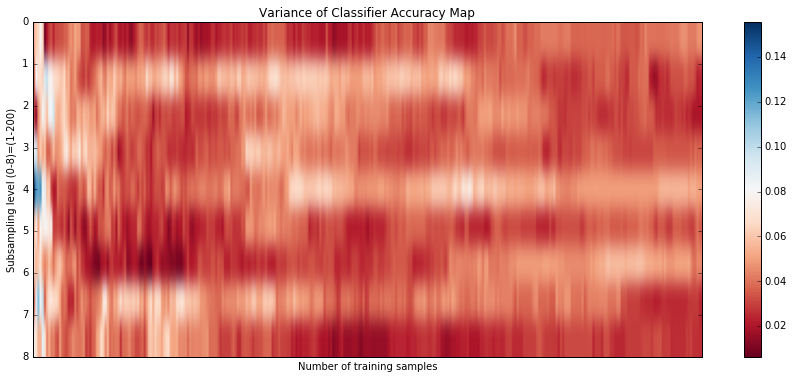

In [73]:
%matplotlib inline
plot_learning_surface(learning_surface, "MC optimised Learning surface")

##Useful Functions

In [22]:
def ROC_plot(ax, pr_lst,mean_tpr,mean_fpr,mean_auc,C,gamma,SV):
    for i, (fpr,tpr,roc_auc) in enumerate(pr_lst):
        ax.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    ax.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    ax.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(" $\gamma$ = " + str(gamma) + " C = " + str(C) + " #SV = " + str(sum(SV)))
    ax.legend(loc='best', bbox_to_anchor=(0.5, 1.05))
    
    return ax


def plot_learning_curve(lc_dict, roc_dict, hyp_dict, step_list, title, ylim=None):
    train_sizes = lc_dict['train_sizes']
    train_scores = lc_dict['train_scores']
    test_scores = lc_dict['test_scores']
    
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6), dpi=500)
    ax1.set_title(title)

    if ylim is not None:
        plt.ylim(*ylim)
    ax1.set_xlabel("Training examples")
    ax1.set_ylabel("Score")
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.grid()

    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    ax1.legend(loc="best")
    #plot ROC
    C = hyp_dict['C']
    gamma = hyp_dict['gamma']
    SV = hyp_dict['SV']
    pr_lst = roc_dict['pr_lst']
    mean_tpr = roc_dict['mean_tpr']
    mean_fpr = roc_dict['mean_fpr']
    mean_auc = roc_dict['mean_auc']
    ax2 = ROC_plot(ax2, pr_lst,mean_tpr,mean_fpr,mean_auc,C,gamma,SV)
    
    #MC optimisation
    #fitness & freq_acc
    fitness = [step_dict['fitness'] for step_dict in step_list]
    frac_acc = [step_dict['frac_acc'] for step_dict in step_list]
    ax3
    
    
    plt.savefig(title, dpi=500)
    return plt

def plot_learning_surface(learning_surface, title):

    fig=plt.figure(figsize=(15, 6), dpi=100)
    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), dpi=500)
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    steplist = []
    for i, sample in enumerate(learning_surface):
        lc_dict = sample['learning_curve']
        train_sizes = lc_dict['train_sizes']
        test_scores = lc_dict['test_scores']
        test_scores_mean = np.mean(test_scores, axis=1)
        steplist.append(sample['sub_level'])
    
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    plt.savefig(title, dpi=500)
    
    ##
    fig=plt.figure(figsize=(15, 6), dpi=100)
    meanscore = []
    varscore=[]
    for i, sample in enumerate(learning_surface):
        lc_dict = sample['learning_curve']
        train_sizes = lc_dict['train_sizes']
        test_scores = lc_dict['test_scores']
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        meanscore.append(test_scores_mean)
        varscore.append(test_scores_std)
    title = "Mean Accuracy"
    plt.title(title)
    plt.ylabel("Accuracy")
    plt.xlabel("subsampled every:")
    plt.plot(steplist, np.mean(meanscore, axis=1), 'o-', color="g",
                label="Cross-validation score")
    plt.savefig(title, dpi=500)
    
    ##
    fig=plt.figure(figsize=(15, 6), dpi=100)
    plt.title("Mean Variance of Accuracy")
    plt.ylabel("Stdev of CV scores")
    plt.xlabel("subsampled every:")
    plt.plot(steplist, np.mean(varscore, axis=1), 'o-', color="g",
                label="Cross-validation score")
    plt.savefig(title, dpi=500)
    
    ##
    fig=plt.figure(figsize=(15, 6), dpi=100)
    title = "Mean Classifier Accuracy Map"
    plt.title(title)
    plt.ylabel("Subsampling level (0-8)=(1-200)")
    plt.xlabel("Number of training samples")
    ax = fig.add_subplot(1,1,1)
    ax.set_xticks([])
    data = np.array(meanscore)
    length = data.shape[0]
    width = data.shape[1]
    print length, width
    print data.shape
    x, y = np.meshgrid(np.arange(length), np.arange(width))
    #ax.plot_surface(x, y, data)
    im = ax.imshow(data, cmap=matplotlib.cm.RdBu, vmin=abs(data).min(), vmax=abs(data).max(), extent=[0, 16, 8, 0])
    im.set_interpolation('kaiser')
    cb = fig.colorbar(im, ax=ax)
    plt.savefig(title, dpi=500)
    
    ##
    fig=plt.figure(figsize=(15, 6), dpi=100)
    title = "Variance of Classifier Accuracy Map"
    plt.title(title)
    plt.ylabel("Subsampling level (0-8)=(1-200)")
    plt.xlabel("Number of training samples")
    ax = fig.add_subplot(1,1,1)
    ax.set_xticks([])
    vardata = np.array(varscore)
    length = vardata.shape[0]
    width = vardata.shape[1]
    print length, width
    print vardata.shape
    x, y = np.meshgrid(np.arange(length), np.arange(width))
    #ax.plot_surface(x, y, data)
    im = ax.imshow(vardata, cmap=matplotlib.cm.RdBu, vmin=abs(vardata).min(), vmax=abs(vardata).max(), extent=[0, 16, 8, 0])
    im.set_interpolation('kaiser')
    cb = fig.colorbar(im, ax=ax)
    plt.savefig(title, dpi=500)
    
    return plt